<a href="https://colab.research.google.com/github/EdVKu/Econophysics_Projects/blob/main/Ej9_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leemos la tabla de índice Paris

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/TSFMT-II(2024-1) Física/ParisIndex-2016-2023.csv', index_col = 0)
df

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-09-18,2023-09-19,2023-09-20,2023-09-21,2023-09-22,2023-09-25,2023-09-26,2023-09-27,2023-09-28,2023-09-29
Close,4522.450195,4537.629883,4480.470215,4403.580078,4333.759766,4312.740234,4378.75,4391.939941,4312.890137,4210.160156,...,7276.140137,7282.120117,7330.790039,7213.899902,7184.819824,7123.879883,7074.02002,7071.790039,7116.240234,7135.060059


Obtenemos serie temporal de retornos nominales para Paris (t está particionado en días).

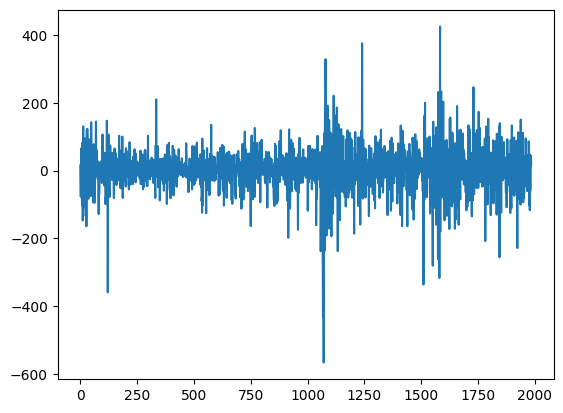

In [ ]:
raw_seq = df.iloc[0,:]
xs = np.arange(len(raw_seq)-1)
raw_seq = raw_seq.diff().dropna()
plt.plot(xs,raw_seq)

Particionamos los datos en entrenamiento y prueba.

In [ ]:
w = [t for t in range(3,5)]
print(range(len(w)))

range(0, 2)


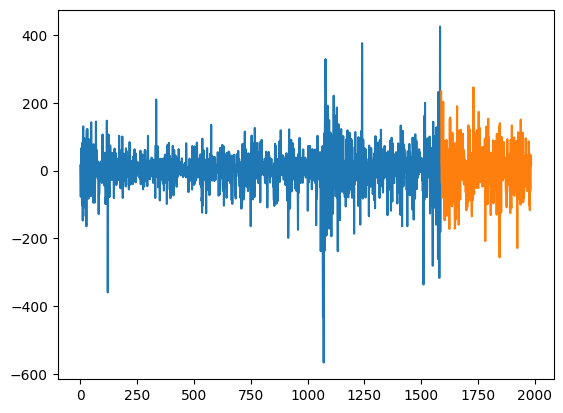

In [ ]:
def train_test(data,p):
    train = data[:int(len(data)*p)]
    test = data[int(len(data)*p):]
    return(train,test)
train_data, test_data = train_test(raw_seq,0.8)
train_x, test_x = train_test(xs,0.8)

plt.plot(train_x,train_data)
plt.plot(test_x, test_data)

Y generamos secuencias discretas de $\varepsilon$ días.

In [ ]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    i = 0
         # find the end of this pattern
    end_ix = i + n_steps
    while end_ix < len(sequence)-1:
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
      X.append(seq_x)
      y.append(seq_y)
      i +=1
      end_ix = i + n_steps


    return(array(X), array(y))

n_steps = 5
# split into samples
X, y = split_sequence(np.array(train_data), n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[ 15.1796875  -57.15966797 -76.89013672 -69.8203125  -21.01953125] 66.009765625
[-57.15966797 -76.89013672 -69.8203125  -21.01953125  66.00976562] 13.18994140625
[-76.89013672 -69.8203125  -21.01953125  66.00976562  13.18994141] -79.0498046875
[-69.8203125  -21.01953125  66.00976562  13.18994141 -79.04980469] -102.72998046875
[ -21.01953125   66.00976562   13.18994141  -79.04980469 -102.72998047] -20.59033203125
[  66.00976562   13.18994141  -79.04980469 -102.72998047  -20.59033203] 82.68994140625
[  13.18994141  -79.04980469 -102.72998047  -20.59033203   82.68994141] -147.3095703125
[ -79.04980469 -102.72998047  -20.59033203   82.68994141 -147.30957031] 81.44970703125
[-102.72998047  -20.59033203   82.68994141 -147.30957031   81.44970703] 130.2900390625
[ -20.59033203   82.68994141 -147.30957031   81.44970703  130.29003906] -25.35986328125
[  82.68994141 -147.30957031   81.44970703  130.29003906  -25.35986328] 45.47998046875
[-147.30957031   81.44970703  130.29003906  -25.35986328   4

In [ ]:
X.shape

(1582, 5)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
#We are working with a univariate series, so the number of features is one,
#for one variable.
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
#Input layer
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
#Hidden layers
model.add(Dense(1))
#output layer
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit the model
model.fit(X, y, epochs=50, verbose=0)  #epochs : modificado a 50

In [ ]:
# Define an array to save the predictions
prediction = []
#Take the last 3 elements of the train data
seq = train_data[-n_steps:]
#Shape them as we need to make a prediction using the model
seq = np.array(seq).reshape((1, n_steps, n_features))

#For the amount of elements in the test data:
for i in range(len(test_data)):
    # We reshape the sequence to the form we need to use the model
    seq = np.array(seq).reshape((1, n_steps, n_features))

    #Predict the next element and add it to the predicitons
    yhat = model.predict(seq, verbose=0)[0][0]
    prediction.append(yhat)

    #Update the sequence by using the prediction
    #and the last two/four elements before it
    seq = [seq[0][1][0], seq[0][2][0], seq[0][3][0], seq[0][4][0], yhat]

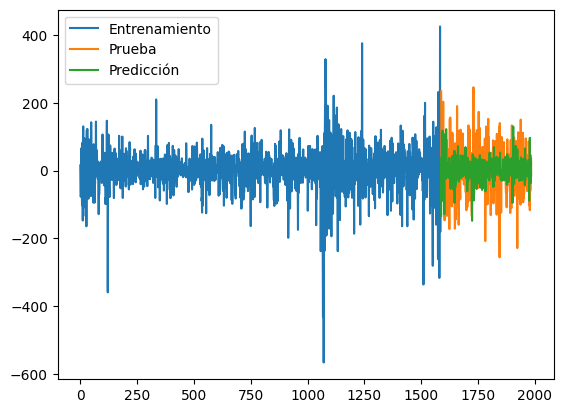

In [ ]:
#Plot the results
plt.plot(train_x, train_data,label="Entrenamiento")
plt.plot(test_x, test_data, label="Prueba")
plt.plot(test_x, prediction, label="Predicción")
plt.legend()